#導入套件

In [23]:
"""
第8週作業：股票價格時間序列預測 - 技術指標比較實驗
實驗架構：
  階段1：全特徵基準測試（建立性能基準）
  階段2：指標分類測試（基於領域知識的特徵工程）
"""

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
import math
import warnings
import os
warnings.filterwarnings('ignore')

# 設定隨機種子，確保結果可重現
torch.manual_seed(42)
np.random.seed(42)

# 設定輸出目錄
if os.path.exists('/mnt/user-data/outputs/'):
    OUTPUT_DIR = '/mnt/user-data/outputs/'
else:
    OUTPUT_DIR = './outputs/'
    os.makedirs(OUTPUT_DIR, exist_ok=True)
# ============================================================================
# 圖表字體設定
# ============================================================================
print("設定繪圖配置...")
plt.rcParams['font.family'] = 'DejaVu Sans'  # 使用英文字體
plt.rcParams['axes.unicode_minus'] = False   # 正確顯示負號
plt.rcParams['figure.figsize'] = (12, 6)     # 預設圖表大小
print("✓ 繪圖配置完成（使用英文標籤）\n")

print("=" * 80)
print("股票價格時間序列預測 - 兩階段特徵工程實驗")
print("=" * 80)
print("階段1：全特徵基準測試（建立性能基準）")
print("階段2：指標分類測試（基於領域知識的特徵工程）")
print("=" * 80)
print(f"輸出目錄: {OUTPUT_DIR}\n")

設定繪圖配置...
✓ 繪圖配置完成（使用英文標籤）

股票價格時間序列預測 - 兩階段特徵工程實驗
階段1：全特徵基準測試（建立性能基準）
階段2：指標分類測試（基於領域知識的特徵工程）
輸出目錄: ./outputs/



#資料收集

In [24]:
# ============================================================================
# [Part 1/8] 資料收集
# ============================================================================
print("="*80)
print("[Part 1/8] 資料收集")
print("="*80)

# 設定股票代號和時間範圍
ticker = "2308.TW"  # 可改為 "2330.TW"(台積電), "TSLA"(特斯拉), "MSFT"(微軟) 等
start_date = "2021-01-01"
end_date = "2025-10-31"

# 使用 yfinance 下載股票資料
stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)
print(f"已下載 {ticker} 股票資料：{start_date} 至 {end_date}")
print(f"原始資料形狀：{stock_data.shape}")

[Part 1/8] 資料收集
已下載 2308.TW 股票資料：2021-01-01 至 2025-10-31
原始資料形狀：(1169, 5)


#特徵工程 - 計算技術指標

In [25]:
# ============================================================================
# [Part 2/8] 特徵工程 - 計算技術指標
# ============================================================================
print("\n" + "="*80)
print("[Part 2/8] 特徵工程 - 計算技術指標")
print("="*80)

print("計算技術指標...")

# ========================================
# 類別 1：趨勢指標 (Trend Indicators)
# ========================================
# 簡單移動平均線 (Simple Moving Average)
stock_data['SMA_5'] = stock_data['Close'].rolling(window=5).mean()    # 5日均線
stock_data['SMA_10'] = stock_data['Close'].rolling(window=10).mean()  # 10日均線
stock_data['SMA_20'] = stock_data['Close'].rolling(window=20).mean()  # 20日均線

# 指數移動平均線 (Exponential Moving Average)
stock_data['EMA_12'] = stock_data['Close'].ewm(span=12, adjust=False).mean()  # 12日EMA
stock_data['EMA_26'] = stock_data['Close'].ewm(span=26, adjust=False).mean()  # 26日EMA

# MACD 指標 (Moving Average Convergence Divergence)
ema_12 = stock_data['Close'].ewm(span=12, adjust=False).mean()
ema_26 = stock_data['Close'].ewm(span=26, adjust=False).mean()
stock_data['MACD'] = ema_12 - ema_26  # MACD線 = 快線 - 慢線
stock_data['MACD_SIGNAL'] = stock_data['MACD'].ewm(span=9, adjust=False).mean()  # 信號線
stock_data['MACD_HIST'] = stock_data['MACD'] - stock_data['MACD_SIGNAL']  # MACD柱狀圖

# ========================================
# 類別 2：動量震盪指標 (Momentum-Oscillator Indicators)
# ========================================
# RSI 指標 (Relative Strength Index) - 相對強弱指標
delta = stock_data['Close'].diff()  # 每日價格變動
gain = delta.mask(delta < 0, 0)     # 只保留上漲部分
loss = -delta.mask(delta > 0, 0)    # 只保留下跌部分（轉正）
avg_gain = gain.ewm(com=13, min_periods=14).mean()  # 14日平均上漲
avg_loss = loss.ewm(com=13, min_periods=14).mean()  # 14日平均下跌
rs = avg_gain / avg_loss  # 相對強度
stock_data['RSI_14'] = 100 - (100 / (1 + rs))  # RSI = 100 - 100/(1+RS)

# 隨機指標 (Stochastic Oscillator)
low_14 = stock_data['Low'].rolling(window=14).min()    # 14日最低價
high_14 = stock_data['High'].rolling(window=14).max()  # 14日最高價
stock_data['STOCH_K'] = 100 * ((stock_data['Close'] - low_14) / (high_14 - low_14))  # %K值
stock_data['STOCH_D'] = stock_data['STOCH_K'].rolling(window=3).mean()  # %D值（3日平均）

# ROC 指標 (Rate of Change) - 變動率指標
stock_data['ROC'] = ((stock_data['Close'] - stock_data['Close'].shift(12)) /
                     stock_data['Close'].shift(12)) * 100

# CCI 指標 (Commodity Channel Index) - 商品通道指數
tp = (stock_data['High'] + stock_data['Low'] + stock_data['Close']) / 3.0  # 典型價格
sma_tp_20 = tp.rolling(20).mean()  # 20日典型價格均線
mean_dev_20 = (tp - sma_tp_20).abs().rolling(20).mean()  # 平均絕對偏差
stock_data['CCI_20'] = (tp - sma_tp_20) / (0.015 * (mean_dev_20 + 1e-8))  # CCI公式

# ========================================
# 類別 3：波動度指標 (Volatility Indicators)
# ========================================
# 布林通道 (Bollinger Bands)
bb_mid = stock_data['Close'].rolling(20).mean()  # 中軌（20日均線）
if isinstance(bb_mid, pd.DataFrame):
    bb_mid = bb_mid.iloc[:, 0]

bb_std = stock_data['Close'].rolling(20).std()  # 標準差
if isinstance(bb_std, pd.DataFrame):
    bb_std = bb_std.iloc[:, 0]

stock_data['BB_MID_20'] = bb_mid.astype(float)  # 中軌
stock_data['BB_UP_20'] = (bb_mid + 2 * bb_std).astype(float)   # 上軌（+2標準差）
stock_data['BB_LOW_20'] = (bb_mid - 2 * bb_std).astype(float)  # 下軌（-2標準差）

# 布林帶寬度
bb_width_20 = (stock_data['BB_UP_20'] - stock_data['BB_LOW_20']) / (bb_mid + 1e-8)
if isinstance(bb_width_20, pd.DataFrame):
    bb_width_20 = bb_width_20.iloc[:, 0]
stock_data['BB_WIDTH_20'] = bb_width_20.astype(float)

# ATR 指標 (Average True Range) - 平均真實波幅
hl = stock_data['High'] - stock_data['Low']  # 最高-最低
hc = (stock_data['High'] - stock_data['Close'].shift(1)).abs()  # 最高-昨收
lc = (stock_data['Low'] - stock_data['Close'].shift(1)).abs()   # 最低-昨收
tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)  # 真實波幅 = 三者最大值
stock_data['ATR_14'] = tr.rolling(window=14, min_periods=14).mean()  # 14日平均

# 歷史波動率 (Historical Volatility)
log_ret = np.log(stock_data['Close'] / stock_data['Close'].shift(1))  # 對數收益率
stock_data['HV_30'] = log_ret.rolling(30).std() * np.sqrt(252)  # 30日波動率（年化）

# Chaikin 波動率
hl_range = (stock_data['High'] - stock_data['Low']).abs()  # 每日價格範圍
ema_hl_10 = hl_range.ewm(span=10, adjust=False).mean()  # 10日EMA
stock_data['ChaikinVol_10'] = 100.0 * (ema_hl_10 - ema_hl_10.shift(10)) / (ema_hl_10.shift(10) + 1e-8)

# ========================================
# 類別 4：成交量指標 (Volume-based Indicators)
# ========================================
# OBV 指標 (On-Balance Volume) - 能量潮指標
price_diff = stock_data['Close'].diff()
volume_direction = np.where(price_diff > 0, stock_data['Volume'],  # 上漲時加入成交量
                            np.where(price_diff < 0, -stock_data['Volume'], 0))  # 下跌時減去
stock_data['OBV'] = volume_direction.cumsum()  # 累計成交量

# VWAP (Volume Weighted Average Price) - 成交量加權平均價
tp = (stock_data['High'] + stock_data['Low'] + stock_data['Close']) / 3.0  # 典型價格
vwap_num = (tp * stock_data['Volume']).cumsum()  # 累計價格*成交量
vwap_den = stock_data['Volume'].cumsum()  # 累計成交量
stock_data['VWAP'] = vwap_num / (vwap_den + 1e-8)  # VWAP = 總金額/總量

# 成交量震盪指標 (Volume Oscillator)
vol_ma_s = stock_data['Volume'].rolling(14).mean()  # 短期成交量均線
vol_ma_l = stock_data['Volume'].rolling(28).mean()  # 長期成交量均線
stock_data['VolOsc_14_28'] = (vol_ma_s - vol_ma_l) / (vol_ma_l + 1e-8)  # 震盪百分比
# ========================================
# 計算目標變數：對數收益率
# ========================================
# 為什麼用對數收益率而非簡單收益率或價格？
#
# 1. 時間可加性：多期收益 = Σ log_return (可直接相加)
# 2. 對稱性：上漲 x% 和下跌 x% 的絕對值相同
# 3. 常態分佈：接近常態分佈，適合統計模型
# 4. 數學性質：與連續複利一致，方便計算波動率
# 5. 穩定性：避免極端值影響，更適合機器學習
#
# 公式：log_return = ln(P_t / P_{t-1})

stock_data['Log_Return'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))

print("趨勢指標 (8個): SMA_5, SMA_10, SMA_20, EMA_12, EMA_26, MACD, MACD_SIGNAL, MACD_HIST")
print("動量震盪指標 (5個): RSI_14, STOCH_K, STOCH_D, CCI_20, ROC")
print("波動度指標 (7個): BB_MID_20, BB_UP_20, BB_LOW_20, BB_WIDTH_20, HV_30, ChaikinVol_10, ATR_14")
print("成交量指標 (3個): OBV, VWAP, VolOsc_14_28")
print(f"總計 23 個特徵（不含 Close 價格）")

# 移除含有 NaN 的資料列
stock_data.dropna(inplace=True)
print(f"移除 NaN 後，資料形狀：{stock_data.shape}")


[Part 2/8] 特徵工程 - 計算技術指標
計算技術指標...
趨勢指標 (8個): SMA_5, SMA_10, SMA_20, EMA_12, EMA_26, MACD, MACD_SIGNAL, MACD_HIST
動量震盪指標 (5個): RSI_14, STOCH_K, STOCH_D, CCI_20, ROC
波動度指標 (7個): BB_MID_20, BB_UP_20, BB_LOW_20, BB_WIDTH_20, HV_30, ChaikinVol_10, ATR_14
成交量指標 (3個): OBV, VWAP, VolOsc_14_28
總計 23 個特徵（不含 Close 價格）
移除 NaN 後，資料形狀：(1131, 29)


#特徵群組

In [26]:
# ============================================================================
# [Part 3/8] 定義特徵群組
# ============================================================================
print("\n" + "="*80)
print("[Part 3/8] 定義特徵群組")
print("="*80)

# 定義所有特徵（不含收盤價）
ALL_FEATURES = [
    'SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26',  # 趨勢指標
    'RSI_14', 'STOCH_K', 'STOCH_D',  # 動量震盪指標
    'MACD', 'MACD_SIGNAL', 'MACD_HIST', 'ROC',  # 動量指標
    'OBV','CCI_20','BB_MID_20','BB_UP_20','BB_LOW_20','BB_WIDTH_20',  # 成交量與布林通道
    'HV_30','ChaikinVol_10','ATR_14','VWAP','VolOsc_14_28',  # 波動度與成交量
]

# 根據領域知識分類指標
# 作業-修改此部分
INDICATOR_GROUPS = {
    'Trend Indicators': ['SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26',
                         'MACD', 'MACD_SIGNAL', 'MACD_HIST'],
    'Momentum-Oscillator Indicators': ['RSI_14', 'STOCH_K', 'STOCH_D', 'CCI_20', 'ROC'],
    'Volatility Indicators': ['BB_MID_20', 'BB_UP_20', 'BB_LOW_20', 'BB_WIDTH_20',
                              'HV_30', 'ChaikinVol_10', 'ATR_14'],
    'Volume-based Indicators': ['OBV', 'VWAP', 'VolOsc_14_28']
}

print("全部特徵（23個特徵，不含收盤價）")
for i, feat in enumerate(ALL_FEATURES, 1):
    print(f"   {i}. {feat}")

print("\n技術指標分類（4個群組）：")
for group_name, features in INDICATOR_GROUPS.items():
    print(f"   - {group_name}: {len(features)} 個特徵")
    print(f"     {features}")

TARGET = 'Log_Return'  # 預測目標：對數收益率


[Part 3/8] 定義特徵群組
全部特徵（23個特徵，不含收盤價）
   1. SMA_5
   2. SMA_10
   3. SMA_20
   4. EMA_12
   5. EMA_26
   6. RSI_14
   7. STOCH_K
   8. STOCH_D
   9. MACD
   10. MACD_SIGNAL
   11. MACD_HIST
   12. ROC
   13. OBV
   14. CCI_20
   15. BB_MID_20
   16. BB_UP_20
   17. BB_LOW_20
   18. BB_WIDTH_20
   19. HV_30
   20. ChaikinVol_10
   21. ATR_14
   22. VWAP
   23. VolOsc_14_28

技術指標分類（4個群組）：
   - Trend Indicators: 8 個特徵
     ['SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26', 'MACD', 'MACD_SIGNAL', 'MACD_HIST']
   - Momentum-Oscillator Indicators: 5 個特徵
     ['RSI_14', 'STOCH_K', 'STOCH_D', 'CCI_20', 'ROC']
   - Volatility Indicators: 7 個特徵
     ['BB_MID_20', 'BB_UP_20', 'BB_LOW_20', 'BB_WIDTH_20', 'HV_30', 'ChaikinVol_10', 'ATR_14']
   - Volume-based Indicators: 3 個特徵
     ['OBV', 'VWAP', 'VolOsc_14_28']


#資料前處理與分割

In [27]:
# ============================================================================
# [Part 4/8] 資料前處理與分割
# ============================================================================
print("\n" + "="*80)
print("[Part 4/8] 資料前處理與分割")
print("="*80)

# 準備特徵與目標變數
X = stock_data[ALL_FEATURES]
y = stock_data[TARGET]

# 時間序列分割：訓練集 80%、驗證集 10%、測試集 10%
total_size = len(stock_data)
train_size = int(total_size * 0.8)
val_size = int(total_size * 0.1)

# 按時間順序分割（重要：時間序列不能隨機打亂）
X_train = X[:train_size]
X_val = X[train_size:train_size + val_size]
X_test = X[train_size + val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size + val_size]
y_test = y[train_size + val_size:]

print(f"資料分割（8/1/1）：")
print(f"   - 訓練集：{X_train.shape[0]} 個樣本")
print(f"   - 驗證集：{X_val.shape[0]} 個樣本")
print(f"   - 測試集：{X_test.shape[0]} 個樣本")

# 特徵標準化（使用 StandardScaler）
# 注意：只用訓練集的統計量來標準化，避免資料洩漏
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # 計算訓練集的均值和標準差
X_val_scaled = scaler.transform(X_val)          # 用訓練集的統計量轉換驗證集
X_test_scaled = scaler.transform(X_test)        # 用訓練集的統計量轉換測試集

print("特徵標準化完成")

# 建立時間序列資料函數
def create_sequences(X, y, lookback):
    """
    將資料轉換為時間序列格式

    參數:
        X: 特徵資料
        y: 目標變數
        lookback: 回看期間（使用過去幾天的資料）

    回傳:
        X_seq: 形狀為 (樣本數, lookback, 特徵數) 的序列
        y_seq: 對應的目標變數
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - lookback):
        X_seq.append(X[i:(i + lookback)])  # 取過去 lookback 天的資料
        y_seq.append(y[i + lookback])       # 預測第 lookback+1 天
    return np.array(X_seq), np.array(y_seq)

# 設定回看期間為 30 天（即用過去30天預測明天）
lookback_period = 30
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, lookback_period)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val.values, lookback_period)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, lookback_period)

print(f"時間序列建立完成（回看期間={lookback_period} 天）")
print(f"   - 訓練序列：{X_train_seq.shape}")
print(f"   - 驗證序列：{X_val_seq.shape}")
print(f"   - 測試序列：{X_test_seq.shape}")


[Part 4/8] 資料前處理與分割
資料分割（8/1/1）：
   - 訓練集：904 個樣本
   - 驗證集：113 個樣本
   - 測試集：114 個樣本
特徵標準化完成
時間序列建立完成（回看期間=30 天）
   - 訓練序列：(874, 30, 23)
   - 驗證序列：(83, 30, 23)
   - 測試序列：(84, 30, 23)


#模型定義

In [28]:
# ============================================================================
# [Part 5/8] 模型定義
# ============================================================================
print("\n" + "="*80)
print("[Part 5/8] 模型定義")
print("="*80)

# 設定運算設備（優先使用 GPU）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備：{device}")

# ========================================
# 模型 1：LSTM 模型
# ========================================
class LSTMModel(nn.Module):
    """
    LSTM (Long Short-Term Memory) 模型
    適合處理時間序列資料，能記憶長期依賴關係
    """
    def __init__(self, input_size, hidden_size=128, output_size=1, dropout=0.1):
        """
        參數:
            input_size: 輸入特徵數量
            hidden_size: LSTM 隱藏層大小
            output_size: 輸出大小（預測值數量）
            dropout: Dropout 比率，防止過擬合
        """
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size

        # LSTM 層
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True, dropout=dropout)

        # Layer Normalization（穩定訓練）
        self.layer_norm = nn.LayerNorm(hidden_size)

        # 全連接層（輸出層）
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        前向傳播
        x: 輸入資料，形狀為 (batch_size, sequence_length, input_size)
        """
        # LSTM 處理序列資料
        lstm_out, _ = self.lstm(x)  # lstm_out: (batch, seq_len, hidden_size)

        # 只取最後一個時間步的輸出
        last_output = lstm_out[:, -1, :]  # (batch, hidden_size)

        # Layer Normalization
        norm_out = self.layer_norm(last_output)

        # 通過全連接層得到預測值
        output = self.linear(norm_out)

        return output

# ========================================
# 模型 2：Transformer 模型
# ========================================
class TransformerModel(nn.Module):
    """
    Transformer 模型
    使用自注意力機制，能同時關注序列中所有位置
    """
    def __init__(self, input_size, d_model=128, nhead=8, num_encoder_layers=2,
                 dim_feedforward=256, dropout=0.1, output_size=1):
        """
        參數:
            input_size: 輸入特徵數量
            d_model: Transformer 的隱藏維度
            nhead: 多頭注意力的頭數（必須整除 d_model）
            num_encoder_layers: Encoder 層數
            dim_feedforward: 前饋網路的維度
            dropout: Dropout 比率
            output_size: 輸出大小
        """
        super(TransformerModel, self).__init__()
        self.d_model = d_model

        # 輸入投影層（將輸入特徵映射到 d_model 維度）
        self.input_projection = nn.Linear(input_size, d_model)

        # 位置編碼（Positional Encoding）
        # Transformer 沒有順序概念，需要手動加入位置資訊
        max_len = 5000
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                            (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)  # 偶數維度用 sin
        pe[:, 1::2] = torch.cos(position * div_term)  # 奇數維度用 cos
        pe = pe.unsqueeze(0)  # (1, max_len, d_model)
        self.register_buffer('pe', pe)  # 註冊為 buffer（不參與訓練）

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer,
                          num_layers=num_encoder_layers)

        # 輸出層
        self.linear = nn.Linear(d_model, output_size)

    def forward(self, x):
        """
        前向傳播
        x: 輸入資料，形狀為 (batch_size, sequence_length, input_size)
        """
        # 投影到 d_model 維度並縮放
        x = self.input_projection(x) * math.sqrt(self.d_model)

        # 加入位置編碼
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]

        # 通過 Transformer Encoder
        transformer_output = self.transformer_encoder(x)

        # 只取最後一個時間步的輸出
        output = self.linear(transformer_output[:, -1, :])

        return output

print("LSTM 模型已定義")
print("Transformer 模型已定義")

# ========================================
# 訓練函數
# ========================================
def train_model(model, train_loader, val_loader, num_epochs=50, lr=1e-3):
    """
    訓練模型的通用函數

    參數:
        model: 要訓練的模型
        train_loader: 訓練資料載入器
        val_loader: 驗證資料載入器
        num_epochs: 訓練輪數
        lr: 學習率

    回傳:
        訓練好的模型
    """
    criterion = nn.MSELoss()  # 使用均方誤差作為損失函數
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  # Adam 優化器

    # Early Stopping 參數
    best_val_loss = float('inf')
    patience = 10  # 容忍驗證集沒改善的輪數
    patience_counter = 0

    for epoch in range(num_epochs):
        # ========== 訓練階段 ==========
        model.train()  # 設定為訓練模式
        train_loss = 0
        for X_batch, y_batch in train_loader:
            # 將資料移到指定設備（CPU/GPU）
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # 清空梯度
            optimizer.zero_grad()

            # 前向傳播
            output = model(X_batch)

            # 計算損失
            loss = criterion(output.squeeze(), y_batch)

            # 反向傳播
            loss.backward()

            # 更新參數
            optimizer.step()

            train_loss += loss.item()

        # ========== 驗證階段 ==========
        model.eval()  # 設定為評估模式
        val_loss = 0
        with torch.no_grad():  # 不計算梯度，節省記憶體
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output.squeeze(), y_batch)
                val_loss += loss.item()

        # 計算平均損失
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)

        # Early Stopping 檢查
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"   提前停止於第 {epoch+1} 輪")
                break

        # 每 10 輪顯示一次進度
        if (epoch + 1) % 10 == 0:
            print(f"   第 {epoch+1}/{num_epochs} 輪 - 訓練損失: {train_loss:.6f}, 驗證損失: {val_loss:.6f}")

    return model

# ========================================
# 評估函數
# ========================================
def evaluate_model(model, X_test_seq, y_test_seq):
    """
    評估模型性能

    參數:
        model: 訓練好的模型
        X_test_seq: 測試集特徵序列
        y_test_seq: 測試集目標變數

    回傳:
        包含 MSE, MAE, RMSE 和預測值的字典
    """
    model.eval()  # 設定為評估模式
    with torch.no_grad():
        # 將測試資料轉換為 Tensor
        X_test_tensor = torch.Tensor(X_test_seq).to(device)

        # 進行預測
        predictions = model(X_test_tensor).squeeze().cpu().numpy()

    # 計算評估指標
    mse = mean_squared_error(y_test_seq, predictions)    # 均方誤差
    mae = mean_absolute_error(y_test_seq, predictions)   # 平均絕對誤差
    rmse = np.sqrt(mse)  # 均方根誤差

    return {'MSE': mse, 'MAE': mae, 'RMSE': rmse, 'predictions': predictions}


[Part 5/8] 模型定義
使用設備：cpu
LSTM 模型已定義
Transformer 模型已定義


#全特徵實驗

In [29]:
# ============================================================================
# [Part 6/8] 全特徵基準實驗
# ============================================================================
print("\n" + "="*80)
print("全特徵基準實驗")
print("="*80)
print(f"使用全部 {len(ALL_FEATURES)} 個特徵建立性能基準")
print("測試模型：LSTM、Transformer、XGBoost")
print("="*80)

# 設定訓練參數
batch_size = 32
num_epochs = 50

# 準備 DataLoader（用於批次載入訓練資料）
"""
  為什麼需要 DataLoader？
  你有很多訓練資料
  X_train_seq.shape = (945, 30, 23)  # 945個樣本
  y_train_seq.shape = (945,)

  如果一次全部餵給模型：
  記憶體不夠（945個樣本太多）
  訓練太慢（計算梯度需要很久）
  容易卡住或當機

  解決方法：分批次（batch）訓練
  每次只餵 32 個樣本
  記憶體可以負荷
  訓練更有效率
"""
"""
  為什麼要轉成 torch.Tensor？
  NumPy array (原始格式)
  X_train_seq: numpy.ndarray

  PyTorch Tensor (深度學習格式)
  torch.Tensor(X_train_seq): torch.Tensor

  原因：
  PyTorch 模型只能處理 Tensor
  Tensor 可以在 GPU 上運算
  支援自動微分（計算梯度）
"""
# TensorDataset - 打包資料 --> 作用：把 X 和 y 配對在一起
train_data = TensorDataset(torch.Tensor(X_train_seq), torch.Tensor(y_train_seq))
val_data = TensorDataset(torch.Tensor(X_val_seq), torch.Tensor(y_val_seq))

"""
DataLoader - 批次載入器
作用：自動分批、打亂、載入資料
"""
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# 儲存基準結果
baseline_results = {}

# ========================================
# 1. 訓練 LSTM 模型
# ========================================
print("\n[1/3] 訓練 LSTM 模型...")
lstm_model = LSTMModel(input_size=len(ALL_FEATURES), hidden_size=128, dropout=0.1).to(device)
lstm_model = train_model(lstm_model, train_loader, val_loader, num_epochs=num_epochs)
baseline_results['LSTM'] = evaluate_model(lstm_model, X_test_seq, y_test_seq)
print(f"LSTM - RMSE: {baseline_results['LSTM']['RMSE']:.6f}, MAE: {baseline_results['LSTM']['MAE']:.6f}")

# ========================================
# 2. 訓練 Transformer 模型
# ========================================
print("\n[2/3] 訓練 Transformer 模型...")
transformer_model = TransformerModel(input_size=len(ALL_FEATURES), d_model=128,
                                     nhead=8, num_encoder_layers=2).to(device)
transformer_model = train_model(transformer_model, train_loader, val_loader, num_epochs=num_epochs)
baseline_results['Transformer'] = evaluate_model(transformer_model, X_test_seq, y_test_seq)
print(f"Transformer - RMSE: {baseline_results['Transformer']['RMSE']:.6f}, MAE: {baseline_results['Transformer']['MAE']:.6f}")

# ========================================
# 3. 訓練 XGBoost 模型
# ========================================
print("\n[3/3] 訓練 XGBoost 模型...")
# XGBoost 不使用序列資料，直接用標準化後的資料
X_train_xgb = X_train_scaled
X_test_xgb = X_test_scaled
y_train_xgb = y_train.values
y_test_xgb = y_test.values

# 建立並訓練 XGBoost 模型
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_xgb, y_train_xgb)

# 預測並評估
xgb_pred = xgb_model.predict(X_test_xgb)
baseline_results['XGBoost'] = {
    'MSE': mean_squared_error(y_test_xgb, xgb_pred),
    'MAE': mean_absolute_error(y_test_xgb, xgb_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test_xgb, xgb_pred)),
    'predictions': xgb_pred
}
print(f"XGBoost - RMSE: {baseline_results['XGBoost']['RMSE']:.6f}, MAE: {baseline_results['XGBoost']['MAE']:.6f}")

print("\n階段 1 完成：全特徵基準已建立")


全特徵基準實驗
使用全部 23 個特徵建立性能基準
測試模型：LSTM、Transformer、XGBoost

[1/3] 訓練 LSTM 模型...
   第 10/50 輪 - 訓練損失: 0.003047, 驗證損失: 0.010477
   第 20/50 輪 - 訓練損失: 0.013393, 驗證損失: 0.005727
   提前停止於第 29 輪
LSTM - RMSE: 0.106210, MAE: 0.098914

[2/3] 訓練 Transformer 模型...
   第 10/50 輪 - 訓練損失: 0.014375, 驗證損失: 0.011175
   提前停止於第 16 輪
Transformer - RMSE: 0.250193, MAE: 0.243497

[3/3] 訓練 XGBoost 模型...
XGBoost - RMSE: 0.018687, MAE: 0.013387

階段 1 完成：全特徵基準已建立


#指標分類實驗

#

In [30]:
# ============================================================================
# [Part 7/8] 指標分類實驗
# ============================================================================
print("\n" + "="*80)
print("階段 2：指標分類實驗（基於領域知識）")
print("="*80)
print("測試不同指標類型對不同模型的影響")
print("假設：不同指標特性適合不同的模型架構")
print("="*80)

# 儲存指標分類結果
indicator_results = {
    'LSTM': {},
    'Transformer': {},
    'XGBoost': {},
}

# 對每個指標群組進行實驗
for group_name, group_features in INDICATOR_GROUPS.items():
    print(f"\n{'='*60}")
    print(f"實驗群組：{group_name}")
    print(f"特徵：{group_features}")
    print(f"{'='*60}")

    # ========================================
    # 準備該群組的資料
    # ========================================
    X_group = stock_data[group_features]
    X_train_group = X_group[:train_size]
    X_test_group = X_group[train_size + val_size:]

    # 標準化
    scaler_group = StandardScaler()
    X_train_group_scaled = scaler_group.fit_transform(X_train_group)
    X_test_group_scaled = scaler_group.transform(X_test_group)

    # 建立時間序列
    X_train_group_seq, _ = create_sequences(X_train_group_scaled, y_train.values, lookback_period)
    X_test_group_seq, _ = create_sequences(X_test_group_scaled, y_test.values, lookback_period)

    # ========================================
    # 1. LSTM 訓練
    # ========================================
    print(f"\n[1/3] 訓練 LSTM - {group_name}...")
    group_lstm = LSTMModel(len(group_features), hidden_size=64, dropout=0.1).to(device)
    group_train_data = TensorDataset(torch.Tensor(X_train_group_seq), torch.Tensor(y_train_seq))
    group_train_loader = DataLoader(group_train_data, batch_size=batch_size, shuffle=False)

    # 快速訓練（20輪）
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(group_lstm.parameters(), lr=1e-4)
    for epoch in range(20):
        group_lstm.train()
        for X_batch, y_batch in group_train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = group_lstm(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

    # 評估 LSTM
    result_lstm = evaluate_model(group_lstm, X_test_group_seq, y_test_seq)
    indicator_results['LSTM'][group_name] = result_lstm
    print(f"   LSTM - RMSE: {result_lstm['RMSE']:.6f}, MAE: {result_lstm['MAE']:.6f}")

    # ========================================
    # 2. Transformer 訓練
    # ========================================
    print(f"[2/3] 訓練 Transformer - {group_name}...")
    group_transformer = TransformerModel(len(group_features), d_model=64, nhead=4).to(device)
    optimizer = torch.optim.Adam(group_transformer.parameters(), lr=1e-4)
    for epoch in range(20):
        group_transformer.train()
        for X_batch, y_batch in group_train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = group_transformer(X_batch)
            loss = criterion(output.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

    # 評估 Transformer
    result_transformer = evaluate_model(group_transformer, X_test_group_seq, y_test_seq)
    indicator_results['Transformer'][group_name] = result_transformer
    print(f"   Transformer - RMSE: {result_transformer['RMSE']:.6f}, MAE: {result_transformer['MAE']:.6f}")

    # ========================================
    # 3. XGBoost 訓練
    # ========================================
    print(f"[3/3] 訓練 XGBoost - {group_name}...")
    group_xgb = XGBRegressor(n_estimators=100, max_depth=5, random_state=42)
    group_xgb.fit(X_train_group_scaled, y_train.values)
    xgb_pred_group = group_xgb.predict(X_test_group_scaled)

    # 評估 XGBoost
    indicator_results['XGBoost'][group_name] = {
        'RMSE': np.sqrt(mean_squared_error(y_test.values, xgb_pred_group)),
        'MAE': mean_absolute_error(y_test.values, xgb_pred_group)
    }
    print(f"   XGBoost - RMSE: {indicator_results['XGBoost'][group_name]['RMSE']:.6f}, MAE: {indicator_results['XGBoost'][group_name]['MAE']:.6f}")

print("\n 階段 2 完成：指標分類實驗完成")


階段 2：指標分類實驗（基於領域知識）
測試不同指標類型對不同模型的影響
假設：不同指標特性適合不同的模型架構

實驗群組：Trend Indicators
特徵：['SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26', 'MACD', 'MACD_SIGNAL', 'MACD_HIST']

[1/3] 訓練 LSTM - Trend Indicators...
   LSTM - RMSE: 0.130914, MAE: 0.112546
[2/3] 訓練 Transformer - Trend Indicators...
   Transformer - RMSE: 0.055393, MAE: 0.046185
[3/3] 訓練 XGBoost - Trend Indicators...
   XGBoost - RMSE: 0.031512, MAE: 0.024014

實驗群組：Momentum-Oscillator Indicators
特徵：['RSI_14', 'STOCH_K', 'STOCH_D', 'CCI_20', 'ROC']

[1/3] 訓練 LSTM - Momentum-Oscillator Indicators...
   LSTM - RMSE: 0.035707, MAE: 0.029330
[2/3] 訓練 Transformer - Momentum-Oscillator Indicators...
   Transformer - RMSE: 0.045137, MAE: 0.033779
[3/3] 訓練 XGBoost - Momentum-Oscillator Indicators...
   XGBoost - RMSE: 0.017847, MAE: 0.013488

實驗群組：Volatility Indicators
特徵：['BB_MID_20', 'BB_UP_20', 'BB_LOW_20', 'BB_WIDTH_20', 'HV_30', 'ChaikinVol_10', 'ATR_14']

[1/3] 訓練 LSTM - Volatility Indicators...
   LSTM - RMSE: 0.096031, MAE: 0.07584

#結果視覺化與分析


[Part 8/8] 結果視覺化與分析


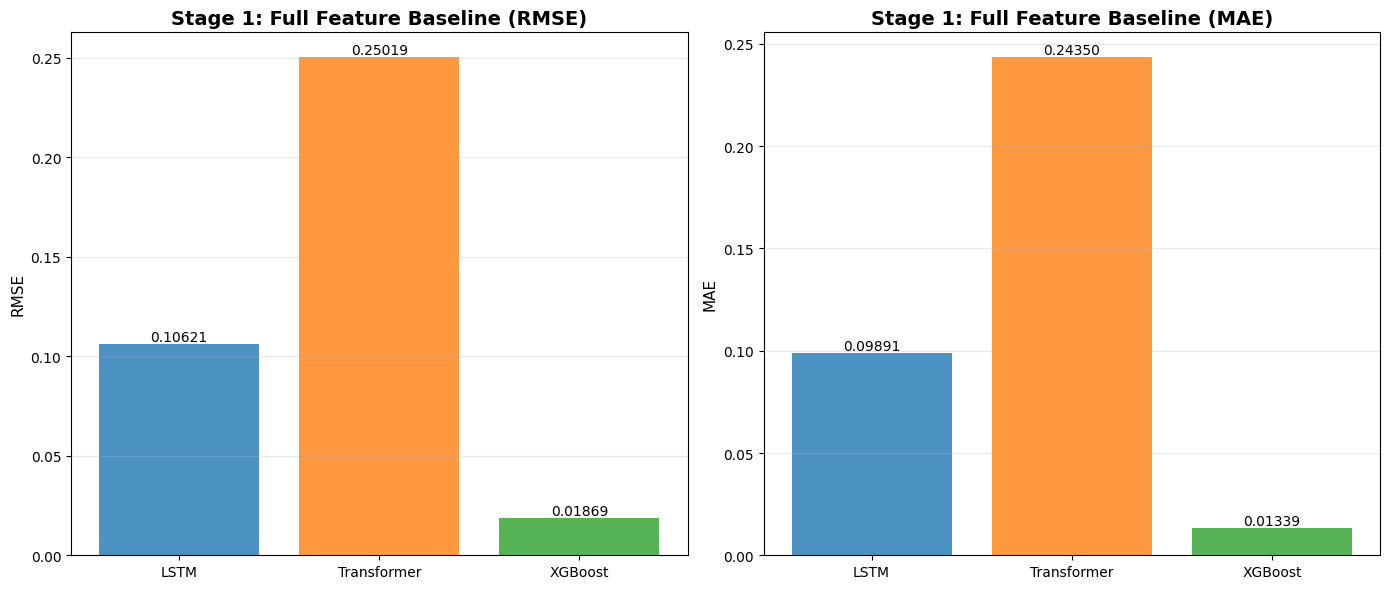

圖表 1：基準比較已儲存


In [31]:
# ============================================================================
# [Part 8/8] 結果視覺化與分析
# ============================================================================
print("\n" + "="*80)
print("[Part 8/8] 結果視覺化與分析")
print("="*80)

# ========================================
# 圖表 1：基準比較（RMSE & MAE）
# ========================================
fig1 = plt.figure(figsize=(14, 6))

# 子圖 1：RMSE 比較
ax1 = plt.subplot(1, 2, 1)
models = list(baseline_results.keys())
rmse_values = [baseline_results[m]['RMSE'] for m in models]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = ax1.bar(models, rmse_values, color=colors, alpha=0.8)
ax1.set_title('Stage 1: Full Feature Baseline (RMSE)', fontsize=14, fontweight='bold')
ax1.set_ylabel('RMSE', fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

# 在柱子上標註數值
for bar, val in zip(bars, rmse_values):
    height = bar.get_height()
    if not np.isnan(height):
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.5f}', ha='center', va='bottom', fontsize=10)

# 子圖 2：MAE 比較
ax2 = plt.subplot(1, 2, 2)
mae_values = [baseline_results[m]['MAE'] for m in models]
bars = ax2.bar(models, mae_values, color=colors, alpha=0.8)
ax2.set_title('Stage 1: Full Feature Baseline (MAE)', fontsize=14, fontweight='bold')
ax2.set_ylabel('MAE', fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, mae_values):
    height = bar.get_height()
    if not np.isnan(height):
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.5f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '01_baseline_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("圖表 1：基準比較已儲存")

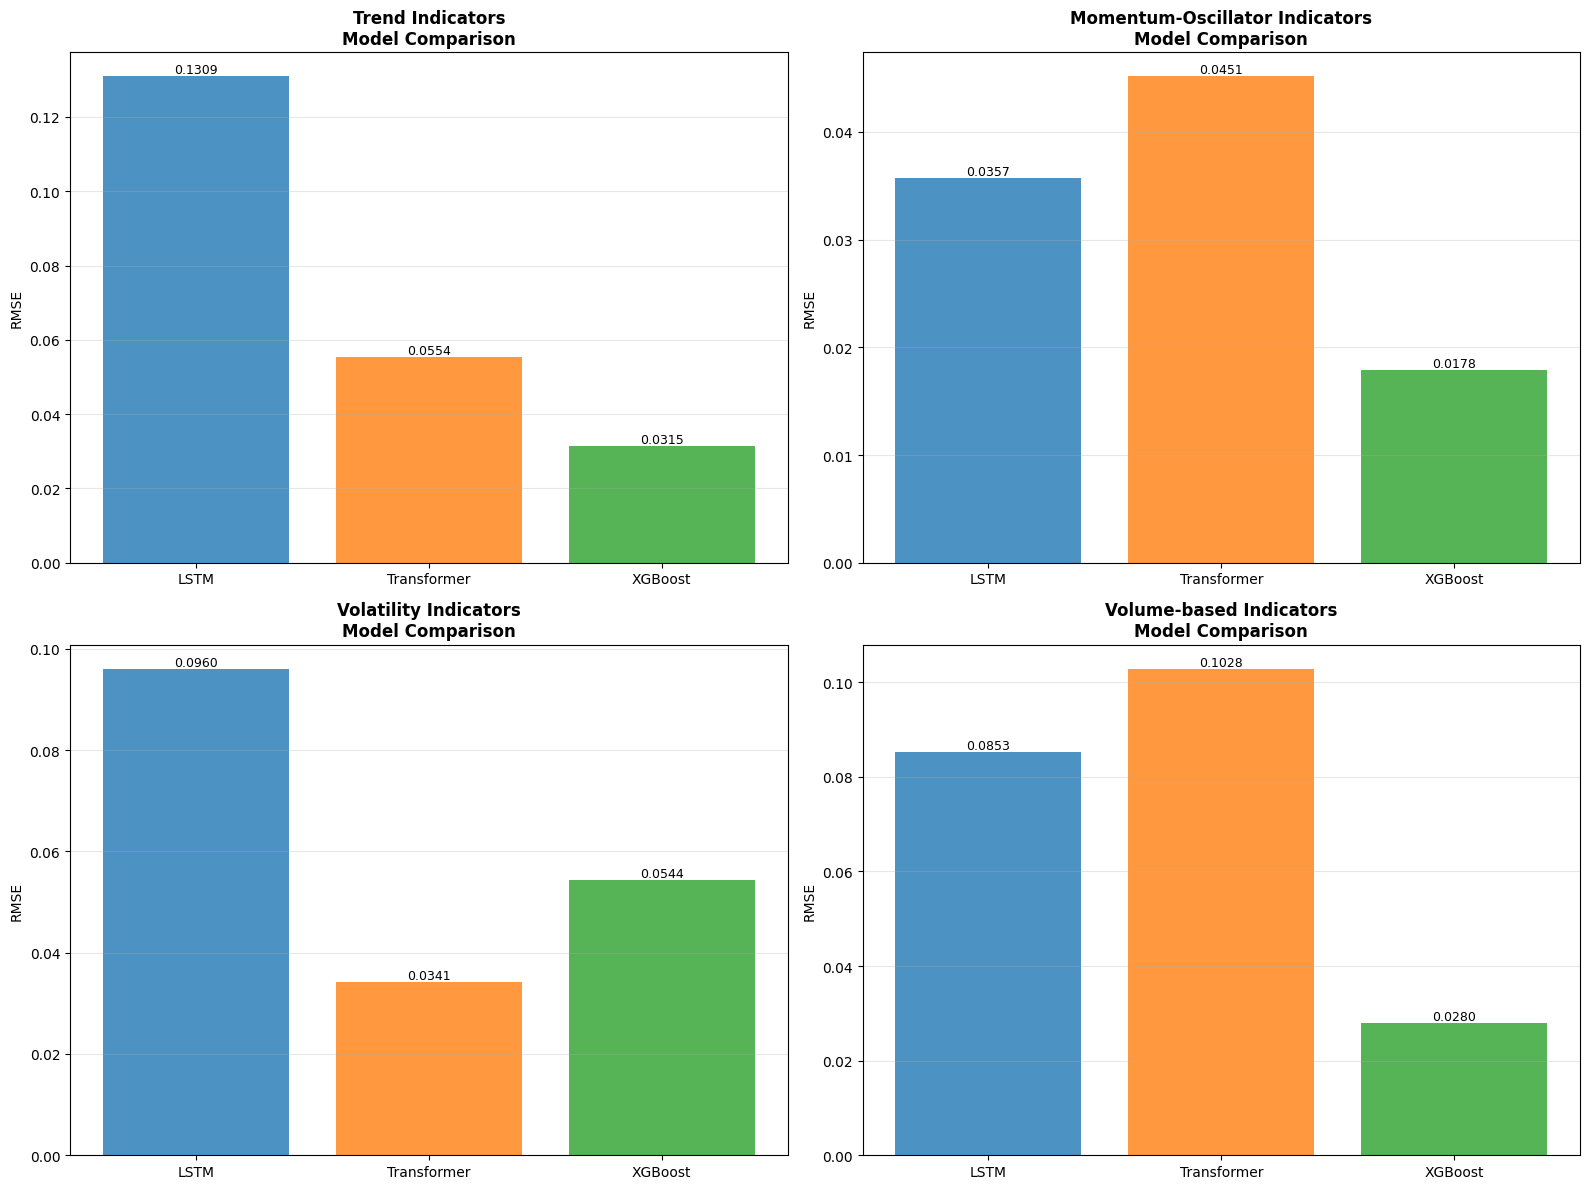

圖表 2：各指標的模型比較已儲存


In [32]:
# ========================================
# 圖表 2：各指標群組的模型比較
# ========================================
fig2 = plt.figure(figsize=(16, 12))

groups = list(INDICATOR_GROUPS.keys())
model_names = ['LSTM', 'Transformer', 'XGBoost']

for idx, group_name in enumerate(groups, 1):
    ax = plt.subplot(2, 2, idx)

    # 收集該指標群組下各模型的 RMSE
    rmse_vals = []
    for model in model_names:
        if group_name in indicator_results[model]:
            rmse = indicator_results[model][group_name]['RMSE']
            rmse_vals.append(rmse if not np.isnan(rmse) else 0)
        else:
            rmse_vals.append(0)

    # 繪製柱狀圖
    x_pos = np.arange(len(model_names))
    bars = ax.bar(x_pos, rmse_vals, color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(model_names, rotation=0)
    ax.set_title(f'{group_name}\nModel Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel('RMSE', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

    # 標註數值
    for bar, val in zip(bars, rmse_vals):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '02_indicator_model_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("圖表 2：各指標的模型比較已儲存")

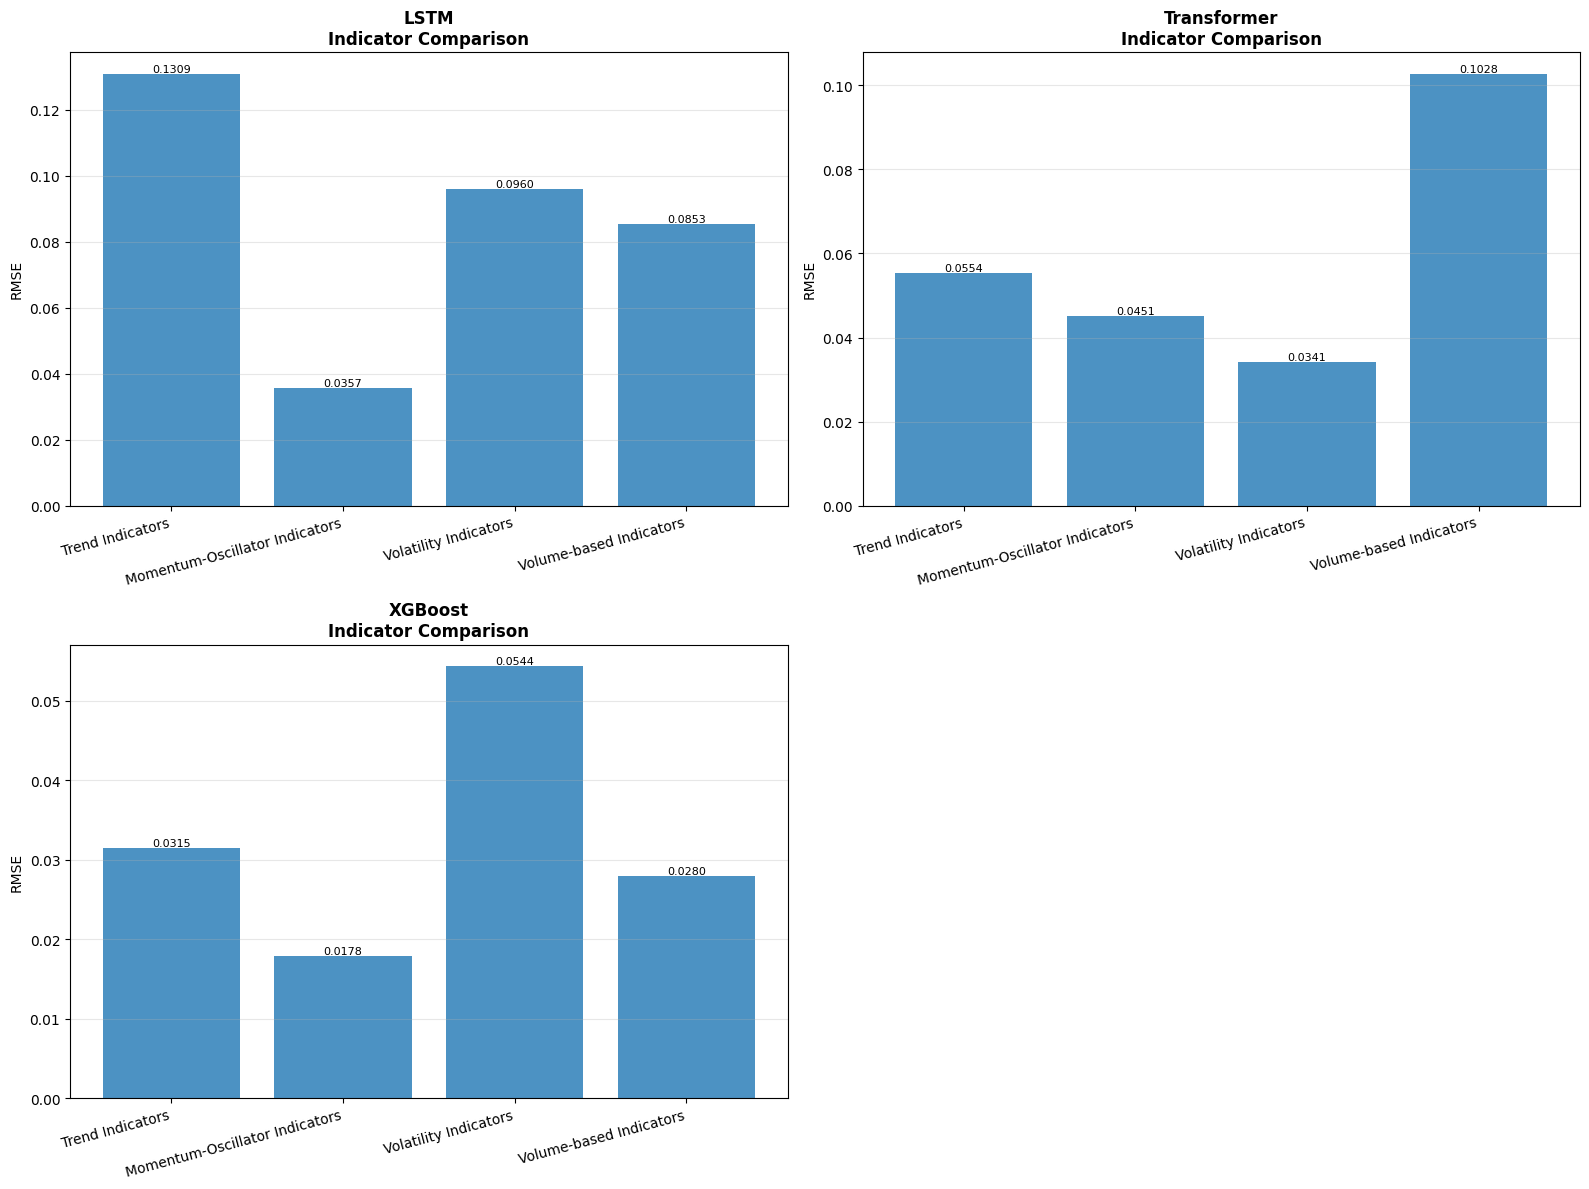

圖表 3：各模型的指標比較已儲存


In [33]:
# ========================================
# 圖表 3：各模型的指標比較
# ========================================
fig3 = plt.figure(figsize=(16, 12))

for idx, model_name in enumerate(model_names, 1):
    ax = plt.subplot(2, 2, idx)

    # 收集該模型在各指標群組的 RMSE
    rmse_vals = []
    for group in groups:
        if group in indicator_results[model_name]:
            rmse = indicator_results[model_name][group]['RMSE']
            rmse_vals.append(rmse if not np.isnan(rmse) else 0)
        else:
            rmse_vals.append(0)

    # 繪製柱狀圖
    x_pos = np.arange(len(groups))
    bars = ax.bar(x_pos, rmse_vals, alpha=0.8)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(groups, rotation=15, ha='right')
    ax.set_title(f'{model_name}\nIndicator Comparison', fontsize=12, fontweight='bold')
    ax.set_ylabel('RMSE', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

    # 標註數值
    for bar, val in zip(bars, rmse_vals):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{val:.4f}', ha='center', va='bottom', fontsize=8, rotation=0)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '03_model_indicator_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("圖表 3：各模型的指標比較已儲存")

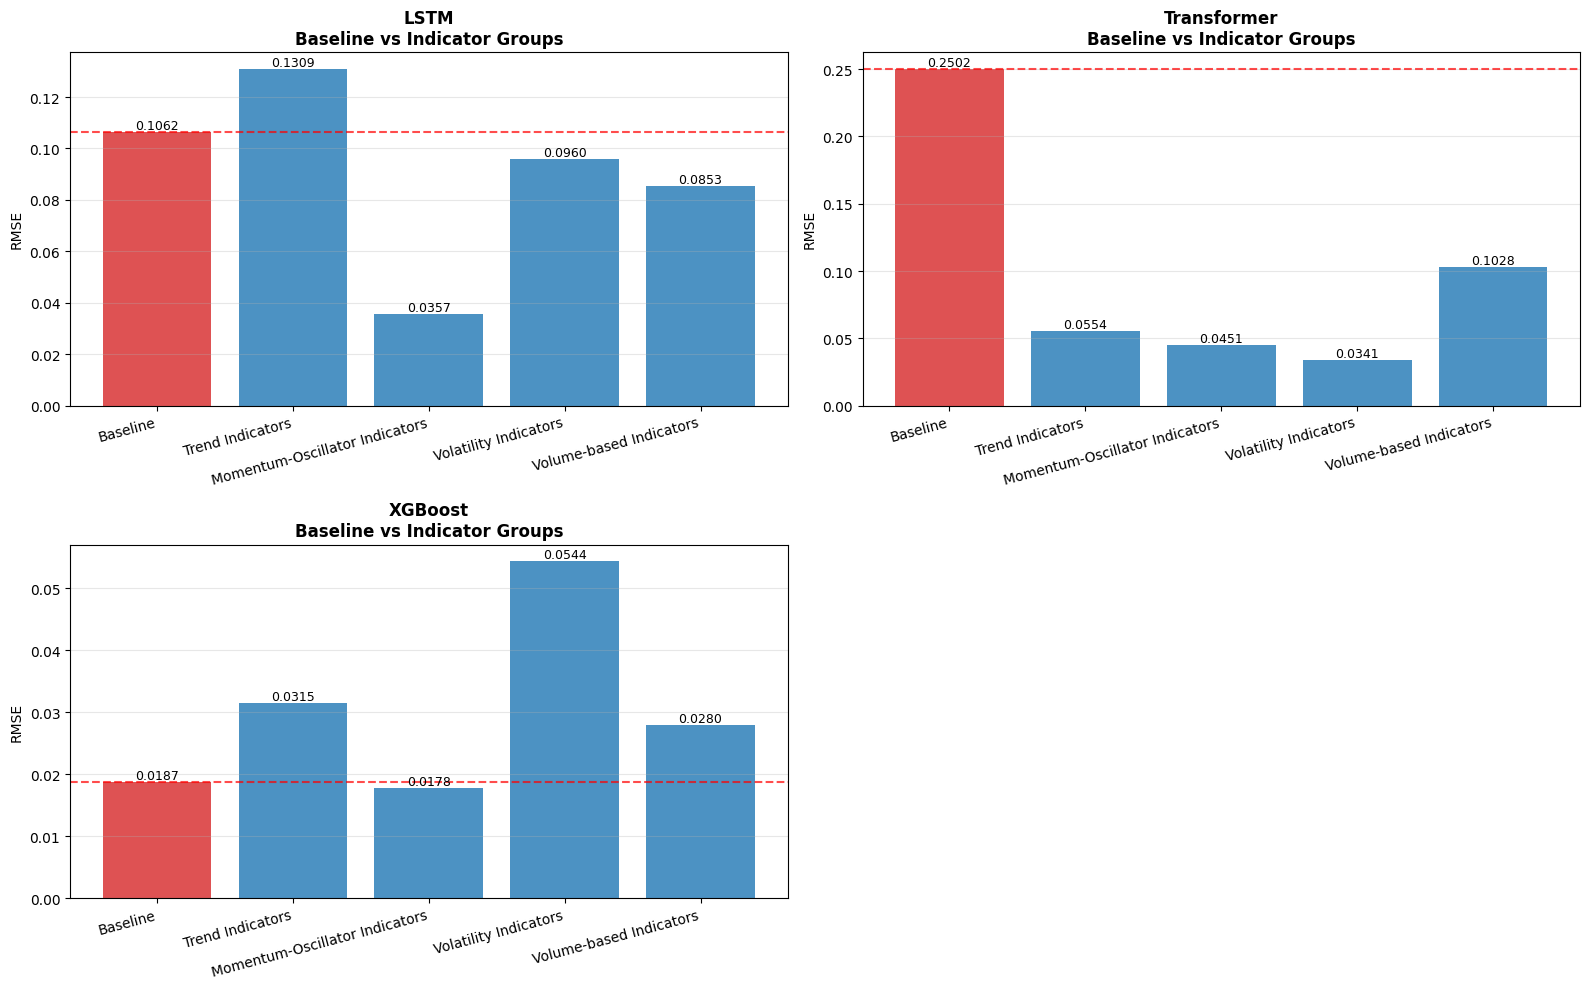

圖表 4：基準 vs 指標比較已儲存


In [34]:
# ========================================
# 圖表 4：基準 vs 指標群組比較
# ========================================
fig4 = plt.figure(figsize=(16, 10))

for idx, model_name in enumerate(model_names, 1):
    ax = plt.subplot(2, 2, idx)

    # 獲取基準 RMSE
    baseline_rmse = baseline_results[model_name]['RMSE'] if not np.isnan(baseline_results[model_name]['RMSE']) else 0

    # 獲取各指標群組的 RMSE
    group_labels = ['Baseline'] + groups
    rmse_vals = [baseline_rmse]
    for group in groups:
        if group in indicator_results[model_name]:
            rmse = indicator_results[model_name][group]['RMSE']
            rmse_vals.append(rmse if not np.isnan(rmse) else 0)
        else:
            rmse_vals.append(0)

    # 繪製柱狀圖（基準用紅色，其他用藍色）
    x_pos = np.arange(len(group_labels))
    colors_chart = ['#d62728'] + ['#1f77b4'] * len(groups)
    bars = ax.bar(x_pos, rmse_vals, color=colors_chart, alpha=0.8)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(group_labels, rotation=15, ha='right')
    ax.set_title(f'{model_name}\nBaseline vs Indicator Groups', fontsize=12, fontweight='bold')
    ax.set_ylabel('RMSE', fontsize=10)
    ax.grid(True, alpha=0.3, axis='y')

    # 標註數值
    for bar, val in zip(bars, rmse_vals):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2., bar.get_height(),
                   f'{val:.4f}', ha='center', va='bottom', fontsize=9)

    # 添加基準參考線
    ax.axhline(y=baseline_rmse, color='r', linestyle='--', linewidth=1.5, alpha=0.7)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, '04_baseline_vs_indicators.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()
print("圖表 4：基準 vs 指標比較已儲存")

In [35]:
# ============================================================================
# 生成實驗報告
# ============================================================================
print("\n" + "="*80)
print("生成實驗報告")
print("="*80)

report = f"""
{'='*80}
股票價格時間序列預測 - 兩階段特徵工程實驗報告
{'='*80}

實驗設定：
-----------
股票代號：{ticker}
時間範圍：{start_date} 至 {end_date}
訓練/驗證/測試：{train_size}/{val_size}/{len(stock_data)-train_size-val_size} 個樣本
回看期間：{lookback_period} 天
總特徵數：{len(ALL_FEATURES)}

{'='*80}
階段 1：全特徵基準結果
{'='*80}

使用全部 {len(ALL_FEATURES)} 個特徵建立基準性能：

┌──────────────┬──────────────┬──────────────┬──────────────┐
│    模型      │     MSE      │     MAE      │     RMSE     │
├──────────────┼──────────────┼──────────────┼──────────────┤
"""

for model in model_names:
    mse = baseline_results[model]['MSE']
    mae = baseline_results[model]['MAE']
    rmse = baseline_results[model]['RMSE']
    report += f"│ {model:12s} │ {mse:>12.6f} │ {mae:>12.6f} │ {rmse:>12.6f} │\n"

report += """└──────────────┴──────────────┴──────────────┴──────────────┘

"""

report += f"""
{'='*80}
階段 2：指標分類結果
{'='*80}

測試 4 種指標類型對不同模型的影響：

"""

for group_name in groups:
    report += f"\n{group_name}:\n"
    report += f"  特徵：{INDICATOR_GROUPS[group_name]}\n"
    for model in model_names:
        if group_name in indicator_results[model]:
            rmse = indicator_results[model][group_name]['RMSE']
            mae = indicator_results[model][group_name]['MAE']
            if not np.isnan(rmse):
                # 計算與基準的百分比差異
                baseline_rmse = baseline_results[model]['RMSE']
                pct_diff = ((rmse - baseline_rmse) / baseline_rmse) * 100
                report += f"  - {model:12s}: RMSE={rmse:.6f}, MAE={mae:.6f} (相較基準：{pct_diff:+.1f}%)\n"
            else:
                report += f"  - {model:12s}: N/A\n"

# 找出每個指標群組的最佳模型
for group_name in groups:
    best_model = None
    best_rmse = float('inf')
    for model in model_names:
        if group_name in indicator_results[model]:
            rmse = indicator_results[model][group_name]['RMSE']
            if not np.isnan(rmse) and rmse < best_rmse:
                best_rmse = rmse
                best_model = model
    if best_model:
        report += f"   - {group_name}：最佳模型為 {best_model} (RMSE: {best_rmse:.6f})\n"

print(report)

# 儲存報告
with open(os.path.join(OUTPUT_DIR, 'Experiment_Report_2Stage.txt'), 'w', encoding='utf-8') as f:
    f.write(report)


生成實驗報告

股票價格時間序列預測 - 兩階段特徵工程實驗報告

實驗設定：
-----------
股票代號：2308.TW
時間範圍：2021-01-01 至 2025-10-31
訓練/驗證/測試：904/113/114 個樣本
回看期間：30 天
總特徵數：23

階段 1：全特徵基準結果

使用全部 23 個特徵建立基準性能：

┌──────────────┬──────────────┬──────────────┬──────────────┐
│    模型      │     MSE      │     MAE      │     RMSE     │
├──────────────┼──────────────┼──────────────┼──────────────┤
│ LSTM         │     0.011280 │     0.098914 │     0.106210 │
│ Transformer  │     0.062596 │     0.243497 │     0.250193 │
│ XGBoost      │     0.000349 │     0.013387 │     0.018687 │
└──────────────┴──────────────┴──────────────┴──────────────┘


階段 2：指標分類結果

測試 4 種指標類型對不同模型的影響：


Trend Indicators:
  特徵：['SMA_5', 'SMA_10', 'SMA_20', 'EMA_12', 'EMA_26', 'MACD', 'MACD_SIGNAL', 'MACD_HIST']
  - LSTM        : RMSE=0.130914, MAE=0.112546 (相較基準：+23.3%)
  - Transformer : RMSE=0.055393, MAE=0.046185 (相較基準：-77.9%)
  - XGBoost     : RMSE=0.031512, MAE=0.024014 (相較基準：+68.6%)

Momentum-Oscillator Indicators:
  特徵：['RSI_14', 'STOCH_K', 'STOCH_D'